# Entrenamiento de modelos

- Modelación del aprendizaje con inteligencia artificial
- TC2034.200
- Profesora: Dra. Lorena B. Martínez Elizalde

| Nombre                         | Matrícula |
| ------------------------------ | --------- |
| Juan Pablo Echeagaray González | A00830646 |
| Emily Rebeca Méndez Cruz       | A00830768 |
| Grace Aviance Silva Aróstegui  | A01285158 |

Fecha: 22 de marzo del 2022

## Librerías

In [28]:
# Librerías básicas
import numpy as np
import pandas as pd
# Visualizaciones
import matplotlib.pyplot as plt
import seaborn as sns
# Librerías de Machine Learning
import tensorflow
import warnings
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Métricas de los modelos
from sklearn.metrics import accuracy_score, recall_score, f1_score
# Tratamiento de bases de datos desbalanceadas
from imblearn.over_sampling import SMOTE
# Guardado de modelos
import pickle
# Medición de tiempo de entrenamiento
import timeit

warnings.filterwarnings("ignore")
plt.style.use('ggplot')


## Lectura y preparación de datos

In [29]:
df = pd.read_csv('../data/clean_data.csv')
X = df.drop(['Cancer'], axis=1)
y = df['Cancer']

X_ovr, y_ovr = SMOTE(random_state=0).fit_resample(X, y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_ovr)

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_ovr, test_size=test_size, random_state=0)


## Creación y entrenamiento de los modelos

### Árbol de decisión

In [30]:
def create_tree(X_train: pd.DataFrame, y_train: pd.Series, this_max_depth: int = 5, this_random_state: int = 0) -> DecisionTreeClassifier:
    """Function that created and trains a Decision Tree Classifier.

    Args:
        X_train (pd.DataFrame): Dataframe with the features.
        y_train (pd.Series): Series with the labels.
        this_max_depth (int, optional): Maximum depth of the tree, keep it lower to prevent overfitting. Defaults to 5.
        this_random_state (int, optional): Random state to be used during the training process. Defaults to 0.

    Returns:
        DecisionTreeClassifier: Sklearn Decision Tree Classifier.
    """    
    tree = DecisionTreeClassifier(
        criterion='entropy', max_depth=this_max_depth, random_state=this_random_state)
    tree.fit(X_train, y_train)
    return tree


this_max_depth = 10
dec_tree = create_tree(X_train, y_train, this_max_depth)
pickle.dump(dec_tree, open('../code/trained-models/dec_tree.pkl', 'wb'))


### Support Vector Machine

In [31]:
def create_svm(X_train: pd.DataFrame, y_train: pd.Series, this_random_state: int =0) -> SVC:
    """Function that creats and trains an SVM kernel RBF

    Args:
        X_train (pd.DataFrame): Dataframe with the features
        y_train (pd.Series): Series with the labels
        this_random_state (int, optional): Random state to be used. Defaults to 0.

    Returns:
        SVC: Sklearn SVM classifier
    """    
    svm = SVC(kernel='rbf', random_state=this_random_state)
    svm.fit(X_train, y_train)
    return svm


support_vector_machine = create_svm(X_train, y_train)
pickle.dump(support_vector_machine, open('../code/trained-models/svm.pkl', 'wb'))


### Red Neuronal

In [32]:
def create_network(X: pd.DataFrame, y: pd.Series, n_neurons: int, n_epochs: int, this_test_size: float, this_random_state: int = 0) -> Sequential:
    """Function that creates and trains a Neural Network.

    Args:
        X (pd.DataFrame): Dataframe containing the features.
        y (pd.Series): Series containing the target.
        n_neurons (int): Number of neurons in the hidden layer.
        n_epochs (int): Number of epochs to train the model.
        this_test_size (float): Test size for the train_test_split.
        this_random_state (int, optional): Random state to be used. Defaults to 0.

    Returns:
        Sequential: Keras Sequential model.
    """
    # Set seed for reproducibility
    np.random.seed(42)
    tensorflow.random.set_seed(42)
    X_train, _, y_train, _ = train_test_split(
        X, y, test_size=this_test_size, random_state=this_random_state)
    model = Sequential()
    model.add(Dense(units=n_neurons, activation='relu',
              input_dim=X_train.shape[1]))
    model.add(Dense(units=n_neurons, activation='relu'))
    model.add(Dense(units=n_neurons, activation='relu'))
    model.add(Dense(np.unique(y_train).shape[0], activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=n_epochs, batch_size=10, verbose=0)

    return model

n_neurons = 20
n_epochs = 50
neural_network = create_network(X_train, y_train, n_neurons, n_epochs, test_size)
pickle.dump(neural_network, open('../code/trained-models/neural-network.pkl', 'wb'))


INFO:tensorflow:Assets written to: ram://d6c064e9-5d8c-4b8a-9289-b74fed40932b/assets


### Regresión Logística

In [33]:
def create_log_reg(X_train: pd.DataFrame, y_train: pd.Series, this_random_state: int = 0) -> LogisticRegression:
    """Function that creates and trains a multi-class Logistic Regression.

    Args:
        X_train (pd.DataFrame): Dataframe containing the features.
        y_train (pd.Series): Series containing the target.
        this_random_state (int, optional): Random state to be used during the training process. Defaults to 0.

    Returns:
        LogisticRegression: Sklearn multi-class Logistic Regression.
    """    
    clf = LogisticRegression(multi_class='multinomial', solver='newton-cg', random_state=this_random_state)
    clf.fit(X_train, y_train)
    return clf


log_reg = create_log_reg(X_train, y_train)
pickle.dump(log_reg, open('../code/trained-models/logistic-regression.pkl', 'wb'))


## Comparativa

In [34]:
model_functions = [create_tree, create_svm, create_network, create_log_reg]
models = [dec_tree, support_vector_machine, neural_network, log_reg]
model_names = ['Decision Tree', 'Support Vector Machine', 'Neural Network', 'Logistic Regression']


### Tiempo de entrenamiento

In [35]:
def time_tester(model: callable, X_train: pd.DataFrame, y_train: pd.Series, repetitions: int = 20) -> float:
    """Function that calculates the average training time for a given model.

    Args:
        model (callable): Model to be tested.
        X_train (pd.DataFrame): Dataframe containing the features.
        y_train (pd.Series): Series containing the target.
        repetitions (int, optional): Number of times to repeat the training process. Defaults to 20.

    Returns:
        float: Average training time.
    """    
    if model == create_network:
        t = timeit.repeat(lambda: model(X_train, y_train, n_neurons, n_epochs, test_size), number=1, repeat=repetitions)
    elif model == create_tree:
        t = timeit.repeat(lambda: model(X_train, y_train, this_max_depth), number=1, repeat=repetitions)
    else:
        t = timeit.repeat(lambda: model(X_train, y_train), number=1, repeat=repetitions)

    avg = np.average(t)
    return avg



In [36]:
avg_times = pd.Series(index=model_names)

for model_function, model_name in zip(model_functions, model_names):
    avg = time_tester(model_function, X_train, y_train)
    avg_times[model_name] = avg


### Métricas de precisión

In [37]:
def report_model(model: callable, model_name: str, X_test: pd.DataFrame, y_test: pd.Series) -> dict:
    """Function that reports metrics for a given model.

    Args:
        model (callable): Model to be tested.
        model_name (str): Label for the model.
        X_test (pd.DataFrame): Dataframe containing the features.
        y_test (pd.Series): Series containing the target.

    Returns:
        dict: Dictionary containing the metrics. (Focused on classification)
    """  
    if isinstance(model, Sequential):
        y_pred = np.argmax(model.predict(X_test), axis=1)
        model_score = model.evaluate(X_test, y_test)[1]

    else:
        y_pred = model.predict(X_test)
        model_score = model.score(X_test, y_test)

    return {'Model': model_name,
            'Test Score': model_score,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted')}



In [38]:
results = pd.DataFrame(columns=['Model', 'Test Score', 'Accuracy', 'Recall', 'F1'])

for model, model_name in zip(models, model_names):
    results = results.append(report_model(model, model_name, X_test, y_test), ignore_index=True)


24/24 [==============================] - 0s 3ms/step - loss: 0.5022 - accuracy: 0.8267


### Resultados

In [39]:
# Set results index to the name of the model
results.index = results['Model']
# Merge results with average times
results = results.merge(avg_times.rename('avg_times'), left_index=True, right_index=True)
results.drop('Model', axis=1, inplace=True)
results.to_csv('../code/comparison-results.csv')


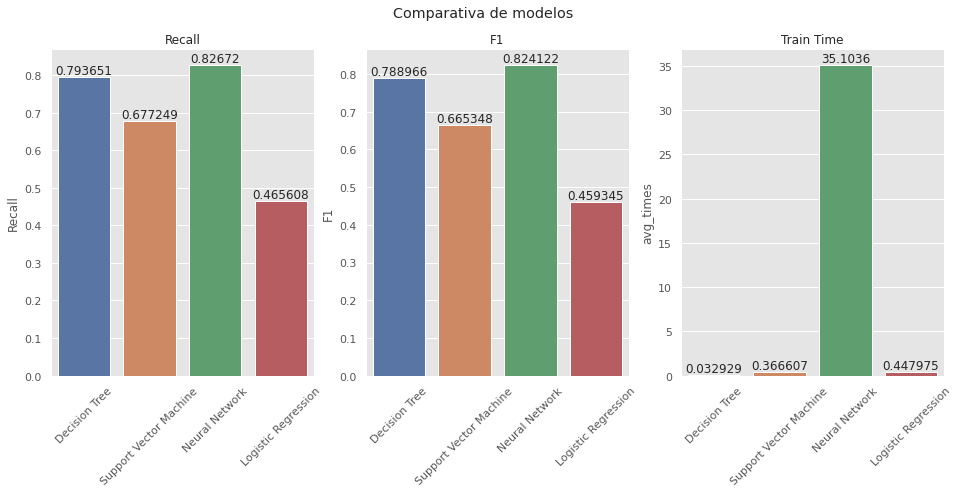

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
sns.set()
titles = ['Recall', 'F1', 'Train Time']
ax = sns.barplot(x=results.index, y='Recall', data=results, ax=axes[0])
ax = sns.barplot(x=results.index, y='F1', data=results, ax=axes[1])
ax = sns.barplot(x=results.index, y='avg_times', data=results, ax=axes[2])

for ax, title in zip(axes, titles):
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)
    ax.bar_label(ax.containers[0])

fig.suptitle('Comparativa de modelos');
